## 1.- Theoretical basis of the methodology for computing Fuel Moisture Content (FMC)

#### In this work we try to match current reflectance values for each pixel with the ones corresponding to field locations where the FMC have been measured on the field.

#### We represent reflectance values for the different spectral bands (plus a synthetic normalised index NDII). To find the similarities between these 6-dimensional vectors we use the angle $ \theta $ from the geometrical definition of the dot product. From the definition we can find the angle span between two vectors as indicated in this figure:

![title](https://upload.wikimedia.org/wikipedia/commons/7/76/Inner-product-angle.svg)

#### For example, the angle between vectors $ a = [0,0,1] $ and $ b = [0,0.7,0.7] $ can be computed implementing this formula in numpy as follows:

In [1]:
import numpy as np

a = np.array([0,0,1])
b = np.array([0,0.7,0.7])

θ = np.arccos((np.dot(a,b))/(np.linalg.norm(a)*np.linalg.norm(b)))
θ

0.7853981633974483

#### This value corresponds to $ \pi / 4 $, as we expect looking at the values of vectors a and b.

#### The proposed method computes this operation matching each value of reflectance with the ones in a simulated radiative transfer Look Up Table (LUT) whose corresponding FMC values are known. To find the closest vectors in this LUT to a new modis pixel, we need to compute the angles between the vector defined by this pixel and each of the values in the LUT. 

#### The following example computes the angles between vector $a$ which represents the reflectance values of a Modis pixel and $b$ which represents the values of the LUT (5 vectors). In numpy we can perform this as a vectorised computation to maximise performance as follows: 

In [2]:
a = np.array([0,0,1])
b = np.array([[0,0.7,0.7],[0,0.5,0.8],[0,0.8,0.5],[0,0.52,0.85],[0,0.4,0.6]])

θ = np.arccos(np.einsum('ij,j->i', b, a)/(np.einsum('i,i->', a, a)**.5*np.einsum('ij,ij->i',b, b)**.5))
θ

array([0.78539816, 0.55859932, 1.01219701, 0.54902514, 0.5880026 ])

#### Now we compute the top 3 most similar entries (smaller $ \theta $). In numpy there is a function which identifies the n-smallest values in an array. Note that the values it returns do not necessarily have to be in order.

In [3]:
top_n = 3

idx = np.argpartition(θ, top_n)[:top_n]

θ[idx]

array([0.54902514, 0.5880026 , 0.55859932])

#### The last step would require us to get the FMC values for these entries in the LUT and compute their median as our FMC estimation for this pixel.  


## 2.- Validation of the methodology using the field data and provided LUT

### 2.1- Computing FMC for field data

#### The data for performing this experiment comes from a Matlab file provided by David Riano which can be found at the NCI:

```
/g/data1a/xc0/user/Riano/FMC/NCI_scripts_v2/run_all_20180411/MODISFMC_collection6_20180411_allMARIANO_wwindows_wFMCaveQCOK3.mat
```
(I keep a copy of this in case it dissapears from that location)

#### Let's start by loading the data containing the vegetation type, Modis reflectance values and FMC values for the field data. The data has been extracted from Matlab and converted into numpy format.

In [5]:
vegtype = np.load("vegtype.npy").astype(np.uint8)
mask = ~np.isnan(vegtype) * (vegtype!=0)
vegtype = vegtype[mask]

x = np.load("fmc_x.npy").T / 10000
x = x[mask,:]
ndii = (x[:,1]-x[:,5])/(x[:,1]+x[:,5])
refs = np.concatenate((x, ndii[:,None]), axis=1)
print(refs.shape)

fmc_obs = np.load("fmc_y.npy")[:,None]

fmc_obs = fmc_obs[mask,:]
print(fmc_obs.shape)

(69622, 8)
(69622, 1)


#### There are almost 70,000 FMC measurements and their corresponding Modis reflectance values (7 bands + NDII)

#### We are going to estimate the FCM values using the proposed methodology and compare with the observed values for this locations.

#### We start by loading the LUT containing the simulated sprectral values for the three types of vegetation:

In [6]:
lut = np.load("LUT.npy")
#bands = [1,2,4,6,7] + NDII
lut = lut[:, [0,1,3,5,6,7]]
lut.shape

(8708, 6)

#### The LUT contains 8708 entries which can be separated by types of vegetation using the following function:

In [7]:
def get_vegtype_idx(veg_type):
    if veg_type == 1.:
        return (0, 2563)
    elif veg_type == 2.:
        return (2563, 4226)
    elif veg_type == 3.:
        return (4226, 8708)

#### This function splits the values in the FMC table by vegetation [1=shrub,2=forest,3=pasture] (!check this values with Marta although the correspondance is not relevant for computing FMC.)

#### The following function identifies the top n closest reflectance vectors (their location or indexes) in the LUT to the input Modis pixel using the methodology previously described.

In [8]:
def get_fmc_idxs(veg_type, ref_modis):
    top_n = 40
    idx = get_vegtype_idx(veg_type)

    # Select Veg type subset from LUT table
    lut_veg = lut[idx[0]:idx[1], :]

    θ = np.arccos(np.einsum('ij,j->i', lut_veg, ref_modis)/(np.einsum('i,i->', ref_modis, ref_modis)**.5*np.einsum('ij,ij->i',lut_veg, lut_veg)**.5))

    idxs = np.argpartition(θ, top_n)[:top_n] + idx[0]

    return idxs

#### The resulting indexes are used to extract the FMC values for the reflectances in the LUT. We stpre this values in the `fmc` array and we make sure the size is consistent with the number of entries in the LUT

In [9]:
fmc = np.load("FMC.npy")
print(fmc.shape)

(8708,)


#### Now we compute the top 40 vectors in the LUT to using the field data Modis reflectance values:

In [10]:
results  = []

for i in range(vegtype.shape[0]):
    results.append(fmc[get_fmc_idxs(vegtype[i], refs[i,[0,1,3,5,6,7]])])
    
results = np.array(results)
results.shape

(69622, 40)

#### This array contains the 40 FMC values corresponding to the closest vectors in the LUT. 

#### Let's see these values for the first point and its median which would be the final FMC value as per the methodology we are following:

In [11]:
print(results[0,:])
np.median(results[0,:])

[ 47.2  51.1  51.1 113.9  81.7  51.1  51.1  51.1  51.1  51.1  81.7  51.1
  87.   51.1  61.8  75.6  87.  110.6  88.9  88.9  47.2  47.2  88.9  47.2
 100.  132.   88.9  61.8  90.5 118.1 100.   60.4 100.   87.  146.2 139.8
  90.5  88.9 113.9 110.6]


87.0

### 2.2.- Statistical analysis of the results

#### First let's plot the estimated vs the observed FMC values to have an idea about the accuracy of the methodology.

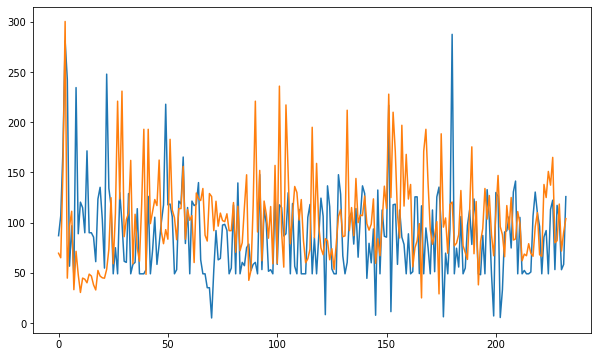

In [12]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
# every 300 points to avoid clutter
plt.plot(np.vstack((np.median(results, axis=1),fmc_obs[:,0])).T[::300,:])